In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

from tabulate import tabulate

## a) Downloading MNIST database, visualizing some sample images and presenting the table for 1 sample image

In [2]:

# Loading MNIST dataset 
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)



# convert dataset to numpy array
data_train = np.array(mnist_trainset.data)
labels_train = np.array(mnist_trainset.targets)
data_test = np.array(mnist_testset.data)
labels_test = np.array(mnist_testset.targets)


# Create pandas dataframe from numpy array and
# splitting dependent and independent variables in X_ and y_
X_train = pd.DataFrame(data_train.reshape(data_train.shape[0], -1), columns=['pixel'+str(i) for i in range(data_train.shape[1]*data_train.shape[2])])
X_test = pd.DataFrame(data_test.reshape(data_test.shape[0], -1), columns=['pixel'+str(i) for i in range(data_test.shape[1]*data_test.shape[2])])
y_test = labels_test

# Making a validation set from the training set 

X_train, X_val, y_train, y_val = train_test_split(X_train, labels_train, test_size=0.2, random_state=0)



### 10 sample images

In [3]:
#Normalize values
X_train = X_train/255.0
X_val  = X_val/255.0
X_test = X_test/255.0

X_train.shape

(48000, 784)

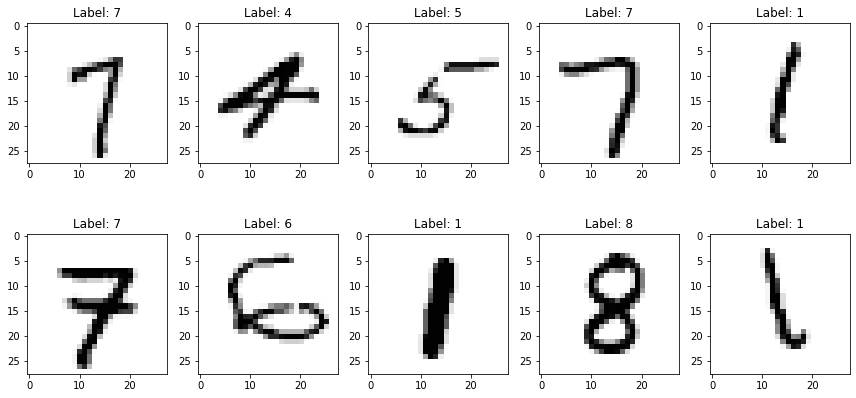

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train.iloc[i].values.reshape(28, 28), cmap='Greys')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

In [5]:
X_test = X_test.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28,28,1)
X_train = X_train.values.reshape(-1, 28,28,1)

In [6]:
print(tabulate(np.squeeze(X_train[0]), tablefmt='grid'))

+---+---+---+---+---+---+---+---+-----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+-----------+---+---+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0         | 0        | 0        | 0        | 0        | 0        | 0         | 0        | 0         | 0        | 0         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+---+-----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+-----------+---+---+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0         | 0        | 0        | 0        | 0        | 0        | 0         | 0        | 0         | 0        | 0         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+---+-----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+-----------+---+---+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 |

**Each pixel value in an image represent the brightness or intensity of each pixel. MNIST dataset contains grayscale images, so a pixel value represent the grayscale between 0 (black) and 255 (white)**

## b) Calibration a ML model on the training set, and calculating its accuracy

In [7]:
#Get one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes = 10)
y_val = keras.utils.to_categorical(y_val, num_classes = 10)

In [8]:
def CNN():
    model = keras.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    return model


In [9]:
model = CNN()

In [10]:
model.compile(optimizer = "Adam", loss = "CategoricalCrossentropy", metrics = "accuracy")

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [12]:
training = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 5, verbose = 1 )

Epoch 1/5
750/750 [==============================] - 14s 18ms/step - loss: 0.3010 - accuracy: 0.9175 - val_loss: 0.1244 - val_accuracy: 0.9647
Epoch 2/5
750/750 [==============================] - 13s 17ms/step - loss: 0.1066 - accuracy: 0.9698 - val_loss: 0.0831 - val_accuracy: 0.9758
Epoch 3/5
750/750 [==============================] - 13s 17ms/step - loss: 0.0774 - accuracy: 0.9777 - val_loss: 0.0676 - val_accuracy: 0.9811
Epoch 4/5
750/750 [==============================] - 13s 17ms/step - loss: 0.0622 - accuracy: 0.9822 - val_loss: 0.0623 - val_accuracy: 0.9810
Epoch 5/5
750/750 [==============================] - 13s 17ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.0582 - val_accuracy: 0.9819


In [13]:
def predict(model, X, y, right_pred, wrong_pred):
    fig, ax = plt.subplots(3,5 , sharex=True, sharey=True, figsize=(15, 15))
    ax = ax.flatten()
    correct_count = 0
    wrong_count = 0
    for i in range(len(X)):
        y_pred = np.argmax(model.predict(X[i].reshape(1, 28, 28, 1)), axis=-1)
        img = X[i].reshape(28, 28)

        if (y_pred == y[i]) & (correct_count < right_pred):
            ax[correct_count].set_title(f'Predicted: {y_pred[0]} Solution: {y[i]}', color = 'b')
            ax[correct_count].imshow(img, cmap='Greys', interpolation='nearest')
            correct_count += 1
        else:
            if (y_pred != y[i]) & (wrong_count < wrong_pred): # limit to imgs/5 wrong predictions
                ax[correct_count+wrong_count].set_title(f'Predicted: {y_pred[0]} Solution: {y[i]}', color ='red')
                ax[correct_count+wrong_count].imshow(img, cmap='Reds', interpolation='nearest')
                wrong_count += 1
        if (correct_count == right_pred) & (wrong_count == wrong_pred):break
    plt.suptitle(f"Here is {correct_count} correct predictions and {wrong_count} wrong predictions")
    plt.show()

1/1 [==============================] - 0s 18ms/step


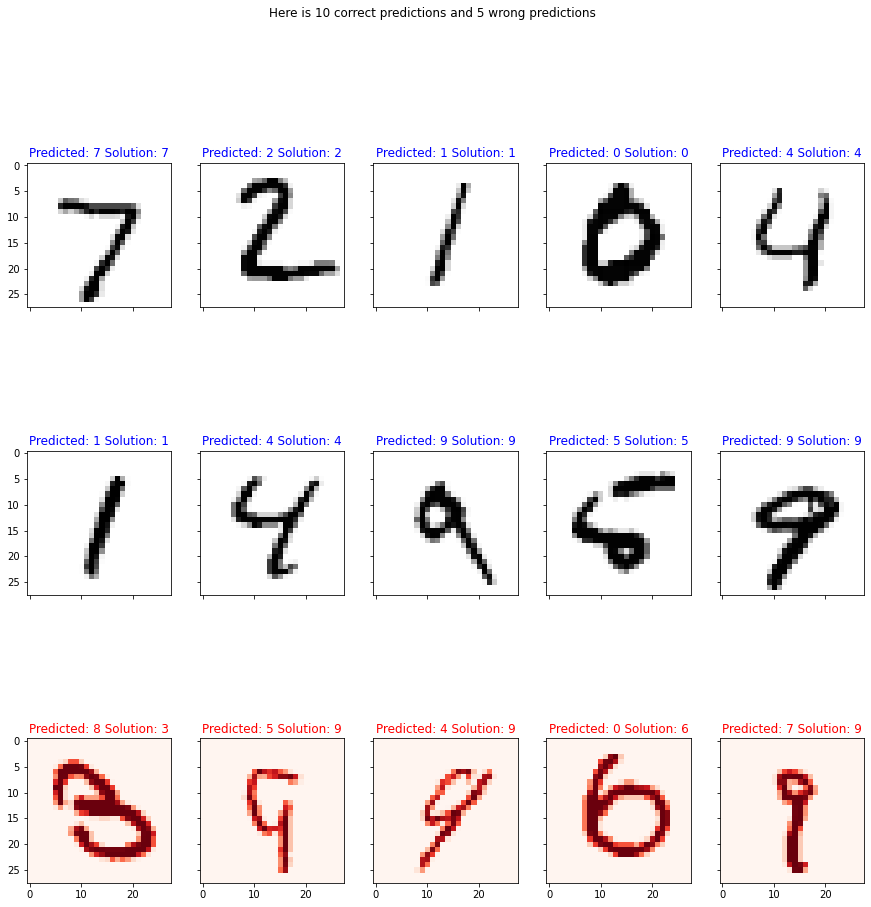

In [14]:
predict(model, X_test,y_test, 10, 5)